# 재무제표를 이용한 분석

In [84]:
import pandas as pd
import datetime
import time
import requests
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.as_node_interactivity = "all"

start = time.time()
df_jongmok = pd.read_csv("./csv/jongmok_list.csv", encoding="euc-kr")[["단축코드", "한글 종목약명"]]
df_jongmok = df_jongmok.rename(columns={"단축코드":"CD", "한글 종목약명":"NM"})
# 데이터 프레임에 적용할 컬럼 정의
list_columns = [
    "DT", "CD", "NM", "ROE", "PER", "PBR", "PROFIT", "INCOME", 
    "FRGN_RT", "END_PRC", "VOL", "PRC_AVG_5", "PRC_VOL_5", "PRC_AVG_10", "PRC_VOL_10", "PRC_MEDIAN", "VOL_MEDIAN", "REMAIN_SELL", "REMAIN_BUY",
]
# 재무제표
list_balance = [
    "CD", "NM", "ROE", "PER", "PBR", "PROFIT", "INCOME"
]
# 일 거래 종합
list_day_summary = [
    "DT", "CD", "NM", 
    "FRGN_RT", 
    "END_PRC", "VOL", "PRC_AVG_5", "PRC_VOL_5", "PRC_AVG_10", "PRC_VOL_10", "PRC_MEDIAN", "VOL_MEDIAN", "REMAIN_SELL", "REMAIN_BUY",
]


list_result = []
list_recent_data = []
list_no_data = []
dt = datetime.datetime.now().strftime("%Y-%m-%d")


def convert_type(df_base, col, as_type):
    df_base[col] = df_base[col].astype(as_type)
    return df_base
    

# 일 거래 종합 - 잔량
def get_remain_deal_amount(cd, nm):
    url = f"https://finance.naver.com/item/sise.naver?code={cd}"
    list_df = pd.read_html(url, encoding="euc-kr")
    
    remain_sell = list_df[3].iloc[0][0]
    remain_buy = list_df[3].iloc[0][2]

    return remain_sell, remain_buy


# 일 거래 종합 - 외국인, 종가, 거래량
def get_day_info(cd, nm):
    
    # 그룹 함수 적용
    def get_grouped(df_base):
        grouped = df_base.groupby(["NM"]).agg({
            "종가": "mean", "거래량": "mean",
        })
        grouped.columns = ["PRC_AVG", "VOL_AVG",]
        grouped = grouped.reset_index()

        return grouped
    
    pg = 1
    headers = {
        "referer" : f"https://finance.naver.com/item/sise_day.naver?code={cd}&page={pg}",    
        "user-agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36" 
    }
    
    url = f"https://finance.naver.com/item/sise_day.naver?code={cd}&page={pg}"
    res = requests.get(url=url, headers=headers)      
    # Pandas : read_html() > table element 추출 가능
    df_data = pd.read_html(res.text)[0].dropna().set_index("날짜").reset_index()
    end_prc = int(df_data.iloc[0][1])
    vol = df_data.iloc[0][6]
    df_data["NM"] = nm
    # 5일평균, 10일 평균, 중위값,
    # prc_avg_5, prc_avg_10, vol_avg_5, vol_avg_10, prc_median, vol_median
    # 5일 평균
    df_grouped = get_grouped(df_data.head(5))
    prc_avg_5 = float(str(df_grouped["PRC_AVG"].iloc[0]))
    vol_avg_5 = float(str(df_grouped["VOL_AVG"].iloc[0]))
    # 10일 평균
    df_grouped = get_grouped(df_data)
    prc_avg_10 = float(str(df_grouped["PRC_AVG"].iloc[0]))
    vol_avg_10 = float(str(df_grouped["VOL_AVG"].iloc[0]))
    # 중앙 값
    prc_median = np.median(list(df_data["종가"]))
    vol_median = np.median(list(df_data["거래량"]))
    # 최근 10일 거래 데이터
    for col in df_data.columns:
        if (col == "NM") or (col == "날짜"): continue
        df_data = convert_type(df_data, col, as_type=int)
        
    list_row = df_data.values.tolist()
    for idx in range(len(list_row)):
        list_recent_data.append(list_row[idx])
    return end_prc, vol, prc_avg_5, vol_avg_5, prc_avg_10, vol_avg_10, prc_median, vol_median


# ROE 값이 기준값 이상인 것만 고른다
def get_roe_more_than_base(cd, nm):
    roe_base = 15.0
    url = f"https://finance.naver.com/item/main.naver?code={cd}"
    
    list_roe = []
    list_per = []
    list_pbr = []
    list_profit = []
    list_income = []
    
    try:
        list_df = pd.read_html(url, encoding="euc-kr")
        df_bs_sheet = list_df[3]
        df_bs_sheet = df_bs_sheet.fillna(0)
        
        roe = 0.0
        
        if ".03" in str(df_bs_sheet["최근 연간 실적"].loc[0]).split(" ")[0]:
            roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.03"][0])
            list_ym = ["2019.03","2020.03","2021.03"]
        elif ".06" in str(df_bs_sheet["최근 연간 실적"].loc[0]).split(" ")[0]:
            roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.06"][0])
            list_ym = ["2019.06","2020.06","2021.06"]
        elif ".09" in str(df_bs_sheet["최근 연간 실적"].loc[0]).split(" ")[0]:
            roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.09"][0])
            list_ym = ["2019.09","2020.09","2021.09"]
        else:
            try:
                roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.12(E)"][0])
                list_ym = ["2018.12","2019.12","2020.12","2021.12(E)"]
            except:
                roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.12"][0])
                list_ym = ["2019.12","2020.12","2021.12"]
    
        if roe >= roe_base:
            # 일 거래 종합
            end_prc, vol, prc_avg_5, vol_avg_5, prc_avg_10, vol_avg_10, prc_median, vol_median = get_day_info(cd, nm)
            # df_recent_data = pd.concat(df_recent_data, df_data)
            # 일 거래 종합 - 잔량
            remain_sell, remain_buy = get_remain_deal_amount(cd, nm)
            # 거래량
            list_deal_vol = list_df[0][2][0].split(" ")
            deal_volume = list_deal_vol[len(list_deal_vol)-1].replace(",","")
            # 외국인
            frgn_rt = float(list_df[6][1].iloc[2].replace("%", ""))
            # 데이터 생성
            for ym in list_ym:
                try:
                    list_roe.append(float(df_bs_sheet.iloc[5].loc["최근 연간 실적", ym][0]))
                    list_per.append(float(df_bs_sheet.iloc[10].loc["최근 연간 실적", ym][0]))
                    list_pbr.append(float(df_bs_sheet.iloc[12].loc["최근 연간 실적", ym][0]))
                    if type(df_bs_sheet.iloc[1].loc["최근 연간 실적", ym][0]) is str:
                        list_profit.append(int(df_bs_sheet.iloc[1].loc["최근 연간 실적", ym][0].replace(",", "")))
                    else:
                        list_profit.append(int(df_bs_sheet.iloc[1].loc["최근 연간 실적", ym][0]))
                    if type(df_bs_sheet.iloc[2].loc["최근 연간 실적", ym][0]) is str:
                        list_income.append(int(df_bs_sheet.iloc[2].loc["최근 연간 실적", ym][0].replace(",", "")))
                    else:
                        list_income.append(int(df_bs_sheet.iloc[2].loc["최근 연간 실적", ym][0]))
                except:
                    pass
            
            list_result.append([dt, "A" + cd, nm, 
                                list_roe, list_per, list_pbr, list_profit, list_income, 
                                frgn_rt, int(end_prc), int(vol), int(prc_avg_5), int(vol_avg_5), int(prc_avg_10), int(vol_avg_10), int(prc_median), int(vol_median), 
                                int(remain_sell), int(remain_buy)
                               ])
    except Exception as e:
        list_no_data.append([cd, nm, e])
        
# get_roe_more_than_base("298540", "더네이쳐홀딩스")
# get_roe_more_than_base("000215", "DL우")
for index, row in df_jongmok.iterrows():
    get_roe_more_than_base(str(row.CD), row.NM)

# Today's dataframe
df_now = pd.DataFrame(data=list_result, columns=list_columns)
df_now[list_balance].to_csv("./csv/balance_sheet.csv", encoding="utf-8-sig", index=False)
# Day Summary Possesion
try:
    # Extract from yesterday csv file and make dataframe
    df_pre = pd.read_csv("./csv/day_summary.csv", encoding="utf-8-sig")
    df_result = pd.concat([df_now[list_day_summary], df_pre]).drop_duplicates()
    # Save result dataframe to csv file 
    df_result.to_csv("./csv/day_summary.csv", encoding="utf-8-sig", index=False)
# No previous data
except:
    df_now[list_day_summary].to_csv("./csv/day_summary.csv", encoding="utf-8-sig", index=False)
    
end = time.time()

print("#" * 100)
# 오류 데이터
df_no_data = pd.DataFrame(data=list_no_data, columns=["CD", "NM", "MESSAGE"])
df_no_data.to_csv("./csv/no_data.csv", encoding="utf-8-sig", index=False)
# 최근 10일 데이터
list_recent_columns=["날짜","종가","전일비","시가","고가","저가","거래량","NM"]
df_recent_data = pd.DataFrame(data=list_recent_data, columns=list_recent_columns)
df_recent_data.to_csv("./csv/recent_deal.csv", encoding="utf-8-sig", index=False)
# 결과
print(len(list_result), " 건")
print(f"Elapsed Seconds: {end - start}")

/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_3475/978948292.py:131: PerformanceWarning: indexing past lexsort depth may impact performance.
  roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.12(E)"][0])
/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_3475/978948292.py:124: PerformanceWarning: indexing past lexsort depth may impact performance.
  roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.06"][0])
/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_3475/978948292.py:134: PerformanceWarning: indexing past lexsort depth may impact performance.
  roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.12"][0])
/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_3475/978948292.py:151: PerformanceWarning: indexing past lexsort depth may impact performance.
  list_roe.append(float(df_bs_sheet.iloc[5].loc["최근 연간 실적", ym][0]))
/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_3475/978948292.py:152: Perfo

####################################################################################################
262  건
Elapsed Seconds: 444.03393292427063


In [93]:
import pandas as pd

list_ordered_key = ["CD", "DT"]
list_using_columns = [
    "NM", "FRGN_RT", "END_PRC", "VOL", "REMAIN_SELL", "REMAIN_BUY",
    "PRC_AVG_5", "PRC_VOL_5", "PRC_AVG_10", "PRC_VOL_10", "PRC_MEDIAN", "VOL_MEDIAN"
]
# 외국인 보유비율
df_calc_base = pd.read_csv("./csv/day_summary.csv", encoding="utf-8-sig")[list_ordered_key + list_using_columns]
# 살려는 양이 더 많은지 확인을 위해
df_calc_base["REMAIN_GAP_BUY"] = df_calc_base["REMAIN_BUY"] - df_calc_base["REMAIN_SELL"]

df_calc_base = df_calc_base.sort_values(list_ordered_key)

def make_rising_dict(df_base, col, base_day):
    # 종목
    list_nm = df_base["NM"].unique()
    # 추세 딕셔너리
    dict_rising = {}
    # 딕셔너리 데이터 생성
    for nm in list_nm:
        dict_rising[nm] = list(df_base[df_base["NM"] == nm][["NM", col]].head(base_day).T.reset_index().loc[1])[1:]
    
    return dict_rising


# 처음 마지막 값
def make_first_last_value(df_base, col):
    df_first_last = df_base.groupby(["NM"]).agg(
        FIRST_VAL=(col, "first"), 
        LAST_VAL=(col, "last")).reset_index()

    df_first_last["GAP"] = df_first_last["LAST_VAL"] - df_first_last["FIRST_VAL"]
    df_first_last["GAP_RT"] = round((df_first_last["GAP"] / df_first_last["FIRST_VAL"]) * 100, 2)

    return df_first_last.sort_values(by=["GAP_RT"], ascending=False).fillna(0.0)

In [94]:
# df_last = df_calc_base[df_calc_base["NM"] == "DB하이텍1우"]
df_last = df_calc_base.groupby(["NM"]).agg(
        PRC_MEDIAN=("PRC_MEDIAN", "last"), 
        VOL_MEDIAN=("VOL_MEDIAN", "last")).reset_index()

df_last

,NM,PRC_MEDIAN,VOL_MEDIAN
0,BGF리테일,175000,58402
1,CJ프레시웨이,37000,94936
2,DB하이텍,70550,760318
3,DB하이텍1우,93750,274
4,DL,59350,40038
...,...,...,...
261,효성티앤씨,475750,33923
262,효성화학,262250,10559
263,휠라홀딩스,33550,341189
264,휴마시스,18725,1866914


In [95]:
# 외국인 보유비율
col = "FRGN_RT"
# 정렬
df_frgn_rt = df_calc_base.sort_values(by=list_ordered_key)
# 추세 딕셔너리
dict_frgn_rt = make_rising_dict(df_frgn_rt, col, 5)
# 최초 마지막 값 구성
df_frgn_rt_calc = make_first_last_value(df_frgn_rt, col)

df_frgn_rt_calc

,NM,FIRST_VAL,LAST_VAL,GAP,GAP_RT
134,아이비김영,0.05,0.51,0.46,920.00
164,이구산업,0.64,1.26,0.62,96.88
231,피제이메탈,0.38,0.64,0.26,68.42
140,알톤스포츠,0.46,0.67,0.21,45.65
99,문배철강,0.34,0.49,0.15,44.12
...,...,...,...,...,...
143,에브리봇,1.00,0.58,-0.42,-42.00
17,KG동부제철우,0.00,0.00,0.00,0.00
35,SBS,0.00,0.00,0.00,0.00
52,금호건설우,0.00,0.00,0.00,0.00


In [96]:
# 종가
col = "END_PRC"
# 정렬
df_end_prc = df_calc_base.sort_values(by=list_ordered_key)
# 추세 딕셔너리
dict_end_prc = make_rising_dict(df_end_prc, col, 5)
# 최초 마지막 값 구성
df_end_prc_calc = make_first_last_value(df_end_prc, col)

df_end_prc_calc = df_end_prc_calc.rename(columns={"LAST_VAL": "LAST_END_PRC"})

df_end_prc_calc

,NM,FIRST_VAL,LAST_END_PRC,GAP,GAP_RT
14,JYP Ent.,51900,56300,4400,8.48
21,LG상사,31350,33650,2300,7.34
235,하림지주,9910,10600,690,6.96
159,유니드,99100,105500,6400,6.46
189,지니언스,11100,11800,700,6.31
...,...,...,...,...,...
63,대양금속,4945,4780,-165,-3.34
231,피제이메탈,6100,5880,-220,-3.61
11,HMM,32600,31150,-1450,-4.45
263,휠라홀딩스,33150,31600,-1550,-4.68


In [97]:
# 거래량
col = "VOL"
# 정렬
df_deal_vol = df_calc_base.sort_values(by=list_ordered_key)
# 추세 딕셔너리
dict_deal_vol = make_rising_dict(df_deal_vol, col, 5)
# 최초 마지막 값 구성
df_deal_vol_calc = make_first_last_value(df_deal_vol, col)

df_deal_vol_calc = df_deal_vol_calc.rename(columns={"LAST_VAL": "LAST_DEAL_VOL"})

df_deal_vol_calc

,NM,FIRST_VAL,LAST_DEAL_VOL,GAP,GAP_RT
235,하림지주,195063,1444684,1249621,640.62
14,JYP Ent.,264267,1597530,1333263,504.51
249,한양증권우,55,316,261,474.55
176,인산가,563650,2804100,2240450,397.49
21,LG상사,311338,1537030,1225692,393.69
...,...,...,...,...,...
52,금호건설우,538,134,-404,-75.09
88,레이크머티리얼즈,2175183,423447,-1751736,-80.53
59,노바렉스,70097,11098,-58999,-84.17
115,서린바이오,994202,138923,-855279,-86.03


In [98]:
# 거래 잔량
col = "REMAIN_GAP_BUY"
# 정렬
df_remain_gap_buy = df_calc_base.sort_values(by=list_ordered_key)
# 추세 딕셔너리
dict_remain_gap_buy = make_rising_dict(df_remain_gap_buy, col, 5)
# 최초 마지막 값 구성
df_remain_gap_buy_calc = make_first_last_value(df_remain_gap_buy, col)

df_remain_gap_buy_calc = df_remain_gap_buy_calc.rename(columns={"LAST_VAL": "LAST_REMAIN_GAP_BUY"})

df_remain_gap_buy_calc

,NM,FIRST_VAL,LAST_REMAIN_GAP_BUY,GAP,GAP_RT
240,한국기업평가,-3,-670,-667,22233.33
94,메가스터디교육,-9,-1917,-1908,21200.00
209,키움증권,253,12164,11911,4707.91
204,코웨이,437,12450,12013,2748.97
219,파미셀,1115,25294,24179,2168.52
...,...,...,...,...,...
3,DB하이텍1우,17,-168,-185,-1088.24
109,사조대림,808,-9142,-9950,-1231.44
178,잉글우드랩,-390,10281,10671,-2736.15
107,빅솔론,-200,7106,7306,-3653.00


In [99]:
# 재무제표 선정 종목
df_balance = pd.read_csv("./csv/balance_sheet.csv", encoding="utf-8-sig")
# 대상 종목의 외국인 추세 추가
df_balance["FRGN_RT"] = df_balance["NM"].apply(lambda X: dict_frgn_rt[X])
# 종가 추세 추가
df_balance["END_PRC"] = df_balance["NM"].apply(lambda X: dict_end_prc[X])
# 거래량 추세 추가
df_balance["VOL"] = df_balance["NM"].apply(lambda X: dict_deal_vol[X])
# 잔량 추세 추가
df_balance["REMAIN_DEAL"] = df_balance["NM"].apply(lambda X: dict_remain_gap_buy[X])

# 가장 최근 중간 값 추출
df_recent_median = df_calc_base.groupby(["CD"]).agg(
    PRC_MEDIAN=("PRC_MEDIAN", "first"), 
    VOL_MEDIAN=("VOL_MEDIAN", "first")).reset_index()

# 이하 필터링 이전 데이터 옆으로 붙이기
# 중간 값
df_balance = pd.merge(
    df_balance, 
    df_recent_median[["CD", "PRC_MEDIAN", "VOL_MEDIAN"]], 
    how="inner", 
    on=["CD"])
# 종가
df_balance = pd.merge(
    df_balance,
    df_end_prc_calc[["NM", "LAST_END_PRC"]],
    how="inner", 
    on=["NM"])
# 거래량
df_balance = pd.merge(
    df_balance,
    df_deal_vol_calc[["NM", "LAST_DEAL_VOL"]],
    how="inner", 
    on=["NM"])
# 거랭 잔량
df_balance = pd.merge(
    df_balance,
    df_remain_gap_buy_calc[["NM", "LAST_REMAIN_GAP_BUY"]],
    how="inner", 
    on=["NM"])

df_balance

,CD,NM,ROE,PER,PBR,PROFIT,INCOME,FRGN_RT,END_PRC,VOL,REMAIN_DEAL,PRC_MEDIAN,VOL_MEDIAN,LAST_END_PRC,LAST_DEAL_VOL,LAST_REMAIN_GAP_BUY
0,A282330,BGF리테일,"[26.46, 18.6, 19.61]","[19.35, 19.09, 17.03]","[4.7, 3.36, 3.11]","[1966, 1622, 1994]","[1514, 1227, 1476]","[30.94, 30.94]","[178000, 179000]","[35341, 28891]","[-4860, -2052]",174000,61437,179000,28891,-2052
1,A000995,DB하이텍1우,"[17.12, 17.39, 23.07, 31.18]","[5.56, 11.74, 13.67, 10.61]","[0.84, 1.86, 2.79, 2.81]","[1130, 1813, 2393, 3810]","[868, 1046, 1660, 2908]","[1.07, 1.07]","[95000, 94800]","[143, 89]","[17, -168]",93750,274,94800,89,-168
2,A000990,DB하이텍,"[17.12, 17.39, 23.07, 31.18]","[5.56, 11.74, 13.67, 10.61]","[0.84, 1.86, 2.79, 2.81]","[1130, 1813, 2393, 3810]","[868, 1046, 1660, 2908]","[23.88, 23.79]","[72500, 72600]","[1502060, 655794]","[49578, 15837]",69450,784288,72600,655794,15837
3,A000215,DL우,"[11.74, 11.84, 26.52]","[5.25, 6.34, 1.47]","[0.59, 1.24, 0.35]","[1360, 1190, 2219]","[7103, 5727, 8750]","[7.2, 7.2]","[37550, 37650]","[1393, 945]","[-515, 214]",36975,700,37650,945,214
4,A001880,DL건설,"[23.04, 23.71, 19.95]","[3.17, 3.94, 3.6]","[0.66, 0.89, 0.66]","[1430, 2034, 2296]","[951, 1493, 1756]","[2.12, 2.16]","[29700, 29700]","[42403, 23972]","[-137, -731]",29825,44486,29700,23972,-731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,A298050,효성첨단소재,"[-19.74, 0.03, 54.69]","[-7.11, 8489.96, 10.65]","[1.53, 2.13, 4.41]","[1583, 342, 4373]","[-529, 68, 3300]","[7.59, 7.54]","[489500, 489500]","[22744, 20673]","[1390, 2123]",492500,31186,489500,20673,2123
258,A298020,효성티앤씨,"[20.86, 25.1, 76.22]","[7.18, 6.68, 2.93]","[1.36, 1.52, 1.58]","[3229, 2666, 14237]","[1220, 1683, 10079]","[11.9, 11.69]","[459000, 467500]","[59036, 26262]","[4283, 92]",478250,36263,467500,26262,92
259,A298000,효성화학,"[21.37, -2.71, 15.58]","[5.25, -42.98, 13.75]","[1.01, 1.24, 1.92]","[1539, 609, 1486]","[878, -116, 704]","[7.27, 7.27]","[256500, 257500]","[21361, 8573]","[3268, 2227]",264250,13030,257500,8573,2227
260,A081660,휠라홀딩스,"[16.03, 23.8, 10.94, 18.63]","[22.78, 12.14, 19.11, 7.23]","[3.3, 2.58, 2.03, 1.21]","[3571, 4707, 3411, 5193]","[2100, 3381, 1977, 3685]","[41.53, 41.43]","[33150, 31600]","[332995, 975347]","[20030, 25316]",33675,340460,31600,975347,25316


In [113]:
import numpy as np

# 값 증가 여부 추가
def check_rising_list_val(col):
    try:
        list_val = eval(col)
    except:
        list_val = col
    
    if len(list_val) < 2:
        return "N"
    
    pre_val = 0
    for val in list_val:
        if pre_val == 0:
            pre_val = val
            continue
        elif val < pre_val:
            return "N"
        
        pre_val = val
            
    return "Y"


list_columns = [
    "CD", "NM",
    "LAST_END_PRC", "PRC_MEDIAN",
    "LAST_DEAL_VOL", "VOL_MEDIAN",
    "ROE", "PER", "PBR", "PROFIT",
    "FRGN_RT", "END_PRC", "VOL", "REMAIN_DEAL"
]

# 계속 증가하는지 여부
# ROE
df_balance["RISING_ROE"] = df_balance["ROE"].apply(lambda X: check_rising_list_val(X))
# 영업이익
df_balance["RISING_PROFIT"] = df_balance["PROFIT"].apply(lambda X: check_rising_list_val(X))
# 외국인
df_balance["RISING_FRGN_RT"] = df_balance["FRGN_RT"].apply(lambda X: check_rising_list_val(X))
# 매수 잔량
df_balance["RISING_REMAIN_DEAL"] = df_balance["REMAIN_DEAL"].apply(lambda X: check_rising_list_val(X))
# 종가가 기준(평균? 중간 값?) 이하인지
df_balance["PRC_BASE"] = np.where(df_balance["LAST_END_PRC"] < df_balance["PRC_MEDIAN"], "Y", "N")
# 거래량이 중간 값 이상인지
df_balance["VOL_BASE"] = np.where(df_balance["LAST_DEAL_VOL"] > df_balance["VOL_MEDIAN"], "Y", "N")
# 매수 대기가 많은지
df_balance["REMAIN_GAP_BUY_BASE"] = np.where(df_balance["LAST_REMAIN_GAP_BUY"] > 0, "Y", "N")


df_selected = df_balance[
    (df_balance["RISING_FRGN_RT"] == "Y") &
    (df_balance["RISING_REMAIN_DEAL"] == "Y") &
    (df_balance["PRC_BASE"] == "Y") &
    # (df_balance["VOL_BASE"] == "Y") &
    (df_balance["REMAIN_GAP_BUY_BASE"] == "Y") &
    (df_balance["RISING_ROE"] == "Y") & 
    (df_balance["RISING_PROFIT"] == "Y")
]

df_selected[list_columns]

,CD,NM,LAST_END_PRC,PRC_MEDIAN,LAST_DEAL_VOL,VOL_MEDIAN,ROE,PER,PBR,PROFIT,FRGN_RT,END_PRC,VOL,REMAIN_DEAL
38,A041140,넥슨지티,22650,22775,906318,2647890,"[2.78, 3.61, 21.55]","[83.98, 118.15, 27.75]","[2.22, 4.06, 5.22]","[-287, 31, 273]","[1.13, 1.24]","[23000, 22650]","[1646523, 906318]","[-93544, 4808]"
47,A084010,대한제강,21400,22000,131092,285492,"[-3.83, 6.73, 10.21, 26.61]","[-8.04, 4.93, 5.26, 2.52]","[0.29, 0.29, 0.45, 0.52]","[46, 420, 818, 2055]","[10.06, 10.06]","[21050, 21400]","[197031, 131092]","[20877, 22505]"
198,A003075,코오롱글로벌우,28900,29025,824,2215,"[3.59, 8.04, 17.83, 30.72]","[11.15, 6.87, 5.96, 3.03]","[0.41, 0.54, 1.04, 0.81]","[768, 1256, 1763, 2539]","[0.82, 0.82]","[29200, 28900]","[714, 824]","[-299, 336]"


In [85]:
df_recent_data = pd.read_csv("./csv/recent_deal.csv", encoding="utf-8-sig")

df_recent_data

,날짜,종가,전일비,시가,고가,저가,거래량,NM
0,2022.03.22,179000,1000,178500,180000,176000,28891,BGF리테일
1,2022.03.21,178000,500,176000,180000,176000,35359,BGF리테일
2,2022.03.18,177500,2500,175000,179500,174000,41056,BGF리테일
3,2022.03.17,175000,4000,180000,182500,175000,62066,BGF리테일
4,2022.03.16,179000,6000,171500,185500,170000,99809,BGF리테일
...,...,...,...,...,...,...,...,...
2645,2022.03.15,17800,500,17350,18150,17350,1945263,휴마시스
2646,2022.03.14,17300,950,18350,18500,17200,2349143,휴마시스
2647,2022.03.11,18250,550,18950,19250,18100,1514782,휴마시스
2648,2022.03.10,18800,150,19000,19900,18650,1692150,휴마시스


In [116]:
import seaborn as sns

def draw_line(df_base, nm, col):
    df_base =df_base.sort_values(by=["날짜"])
    df_jongmok = df_base.query(f"NM == '{nm}'")
    sns.lineplot(data=df_jongmok, x="날짜", y=col)
    
def draw_line_by_list(data):
    sns.lineplot(data=data)

/Users/etlers/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/etlers/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/etlers/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/etlers/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/etlers/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/etlers/opt/anaconda3/lib/python3.9/site-packages/matp

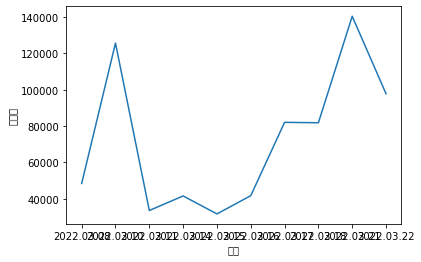

In [117]:
draw_line(df_recent_data, "현대이지웰", "거래량")

<AxesSubplot:xlabel='DT', ylabel='END_PRC'>

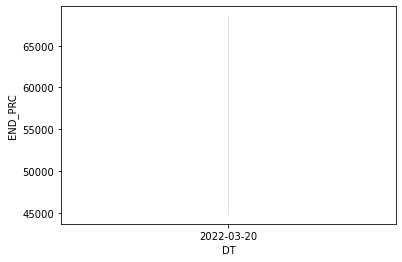

In [149]:
df_calc_base

sns.lineplot(data=df_calc_base, x="DT", y="END_PRC")

In [68]:
df_calc_base.values.tolist()

[['A000060',
  '2022-03-21',
  '메리츠화재',
  11.72,
  41850,
  244225,
  5194,
  12706,
  40060,
  383640,
  38605,
  405478,
  38675,
  411045,
  7512],
 ['A000060',
  '2022-03-22',
  '메리츠화재',
  11.71,
  41800,
  251482,
  6693,
  5675,
  40580,
  345823,
  39085,
  390106,
  39100,
  392104,
  -1018],
 ['A000150',
  '2022-03-21',
  '두산',
  9.07,
  116000,
  49389,
  8053,
  8548,
  117700,
  94358,
  119100,
  147445,
  118500,
  126121,
  495],
 ['A000150',
  '2022-03-22',
  '두산',
  9.01,
  116000,
  59462,
  9008,
  9651,
  117100,
  81549,
  118700,
  140635,
  117250,
  113851,
  643],
 ['A000155',
  '2022-03-21',
  '두산우',
  14.54,
  85000,
  4653,
  478,
  1580,
  85040,
  7701,
  84820,
  11141,
  85100,
  7922,
  1102],
 ['A000155',
  '2022-03-22',
  '두산우',
  14.59,
  86000,
  5086,
  933,
  507,
  85200,
  7047,
  85130,
  11175,
  85300,
  7922,
  -426],
 ['A000157',
  '2022-03-21',
  '두산2우B',
  0.07,
  134500,
  8300,
  545,
  2232,
  145700,
  12785,
  148100,
  20772,
  1475

In [108]:
cd = "298540"
url = f"https://finance.naver.com/item/main.naver?code={cd}"

list_df = pd.read_html(url, encoding="euc-kr")
df_bs_sheet = list_df[3]
df_bs_sheet = df_bs_sheet.fillna(0)

if ".03" in str(df_bs_sheet["최근 연간 실적"].loc[0]).split(" ")[0]:
    roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.03"][0])
    list_ym = ["2019.03","2020.03","2021.03"]
elif ".06" in str(df_bs_sheet["최근 연간 실적"].loc[0]).split(" ")[0]:
    roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.06"][0])
    list_ym = ["2019.06","2020.06","2021.06"]
elif ".09" in str(df_bs_sheet["최근 연간 실적"].loc[0]).split(" ")[0]:
    roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.09"][0])
    list_ym = ["2019.09","2020.09","2021.09"]
else:
    try:
        roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.12(E)"][0])
        list_ym = ["2018.12","2019.12","2020.12","2021.12(E)"]
    except:
        roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.12"][0])
        list_ym = ["2019.12","2020.12","2021.12"]
list_roe = []        
for ym in list_ym:
    try:
        list_roe.append(float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", ym][0]))
    except:
        list_roe.append(0)
        
list_roe

/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_5897/3459785708.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.12(E)"][0])
/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_5897/3459785708.py:27: PerformanceWarning: indexing past lexsort depth may impact performance.
  list_roe.append(float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", ym][0]))


[0.0, 35.28, 33.66, 26.13]

In [125]:
import requests

cd = "005930"
pg = 1

headers = {
    "referer" : f"https://finance.naver.com/item/sise_day.naver?code={cd}&page={pg}",    
    "user-agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36" 
}

url = f"https://finance.naver.com/item/sise_day.naver?code={cd}&page={pg}"
res = requests.get(url=url, headers=headers)      

# Pandas : read_html() > table element 추출 가능
df_data = pd.read_html(res.text)[0].dropna().set_index("날짜").reset_index()

print(df_data.iloc[0][6])

# 5일평균, 10일 평균, 중위값,
# prc_avg_5, prc_avg_10, vol_avg_5, vol_avg_10, prc_median, vol_median

df_data["NM"] = "AAA"
grouped = df_data.groupby(["NM"]).agg({
    "종가": "mean", "거래량": "mean",
})
grouped.columns = ["PRC_AVG_10", "VOL_AVG_10",]
grouped = grouped.reset_index()
grouped

14241145.0


,NM,PRC_AVG_10,VOL_AVG_10
0,AAA,70430.0,14616470.9


In [56]:
import numpy as np

prc_median = np.median(list(df_data["종가"]))
vol_median = np.median(list(df_data["거래량"]))

print(prc_median, vol_median)

28875.0 25592.0


In [60]:
float(str(grouped["PRC_AVG_10"].iloc[0]))

29065.0

In [132]:
df_pre = pd.read_csv("./csv/day_summary.csv", encoding="utf-8-sig")
# df_pre[df_pre["DT"] == "2022-03-20"].drop(axis=1, inplace=True)
df_pre.drop(df_pre.loc[df_pre['DT'] == "2022-03-20"].index, inplace=True)

df_pre.to_csv("./csv/day_summary.csv", encoding="utf-8-sig", index=False)

In [111]:
str(df_bs_sheet["최근 연간 실적"].loc[0]).split(" ")[0]

'2019.12'